In [57]:
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
from pathlib import Path
from folder import StandardFolder
from polars_utils import *

# OUTPUTS
FOLDER_OUT = Path("D:/Prut/Warehouses/output/Jun24/n/af")

# INPUTS
# Cases in our other cohorts
# FOLDER_OC = StandardFolder("H:/Shared drives/Datalake/Data/20240630_fu")
FOLDER_OC = StandardFolder(r"D:\Datalake\Data\20240630_fu_nc")
# Cases not in any cohorts, i.e. new cases
# FOLDER_NC = StandardFolder("H:/Shared drives/Datalake/Loosely_criteria_data/newcase_202406(Jan-June2024)/Data for new case iden 202406")
FOLDER_NC = StandardFolder(r"D:\Datalake\Data\Data for new case iden 202406")

2005-2009 not included.
desktop not included.
er_emr not included.
readme not included.
summary_discharge not included.


In [58]:
# PREV_AF = 'D:/Prut/Warehouses/output/Dec23/n/AF/af_n_21032024.csv'
# prev_af = pd.read_csv(PREV_AF)['ENC_HN'] # 23301
# assert len(prev_af) == prev_af.nunique()
# prev_af: list = pl.scan_parquet('D:/Prut/Warehouses/output/Dec23/wh/complete/AF_warehouse_exported_22-02-2024.parquet.gzip').select(pl.col('ENC_HN')).collect().unique().to_series().to_list() # 23337
# print(len(prev_af))

In [59]:
prev_af: list = pl.scan_csv(r'D:\Prut\Warehouses\output\Dec23\n\AF\af_n_12032024.csv').select(pl.col('ENC_HN')).collect().unique().to_series().to_list()
print(len(prev_af))

23499


In [60]:
# AF standard values
AF_STANDARD = "D:/Prut/Warehouses/std/meds_AF.csv"
af_std_df = pd.read_csv(AF_STANDARD)
af_icd_re = '^I48'
af_drugcodes: list = af_std_df["CODE"].tolist()
af_drugcodes_re: str = "|".join(af_drugcodes)
print(af_drugcodes_re)

COUM2T-|PRAD2C-|ELIQ1T-|LIXI-T-|XARE1T-|XARE2T-|XARE3T-|PRAD1C-|PRAD-C-|ORFR1T-|ORFR2T-|XARE-T-


In [61]:
def get_dx(paths: list[Path], re: str, streaming: bool=False):
    to_concat = []
    # Loop through all files
    for path in paths:
        # Scan and parse dates
        file = (
            scan_file(path)
            .select(pl.col(['ENC_HN', 'D001KEY', 'D035KEY']))
        )
        file = parse_dates(file, 'D001KEY', format="%Y%m%d")
        # Select desired ICD10 codes
        file = file.filter(pl.col('D035KEY').str.contains(re))
        # One day per row
        file = file.group_by(pl.col(['ENC_HN', 'D001KEY'])).agg(pl.col('D035KEY')).with_columns(pl.col('D035KEY').list.unique().list.sort().list.join(', '))
        file = file.collect(streaming=streaming)
        to_concat.append(file)
    return pl.concat(to_concat).unique()


def get_drug(paths: list[Path], re: str, streaming: bool=False):

    to_concat = []
    for path in paths:
        file = scan_file(path)
        # Deal with alternative file structures
        if {'PER_DATE_2', 'SERVICE_ID', 'CAL_SER_AMT'}.issubset(file.columns):
            file = file.rename({'PER_DATE_2': 'D001KEY', 'SERVICE_ID': 'D033KEY', 'CAL_SER_AMT': 'M1022'})
        file = file.select(pl.col(['ENC_HN', 'D001KEY', 'D033KEY', 'M1022']))

        file = parse_dates(file, 'D001KEY', format="%Y%m%d")

        file = file.filter(pl.col('D033KEY').str.contains(re))

        to_concat.append(file.collect(streaming=streaming))

    return pl.concat(to_concat)

In [62]:
med_paths = list(FOLDER_OC.bill.iterdir()) + list(FOLDER_NC.meds.iterdir()) # Some bills some meds, must manually check
med_paths = med_paths[::-1] # remove [:n]

med = get_drug(med_paths, af_drugcodes_re, streaming=True)
med

ENC_HN,D001KEY,D033KEY,M1022
str,date,str,str
"""C90B3BCAF1EB45…",2024-03-18,"""LIXI-T-""","""5.071942446043…"
"""C90B3BCAF1EB45…",2024-03-18,"""LIXI-T-""","""24.92805755395…"
"""EE007C9DFBDE08…",2024-03-25,"""ORFR1T-""","""113"""
"""1DDEE5D2492E14…",2024-03-11,"""ORFR1T-""","""266.6666666666…"
"""B3C7264D401194…",2024-03-21,"""LIXI-T-""","""124.6402877697…"
"""B3C7264D401194…",2024-03-21,"""LIXI-T-""","""25.35971223021…"
"""BD1A2799C063A7…",2024-03-08,"""LIXI-T-""","""6.762589928057…"
"""1B7FE37D1F7ACE…",2024-03-06,"""ORFR1T-""","""33"""
"""647B66F0E187A6…",2024-03-06,"""ORFR1T-""","""11.66666666666…"


In [63]:
med['ENC_HN'].n_unique()

21109

<Axes: title={'center': 'AF drug codes Jan 2010 to Jun 2024'}, xlabel='Drug code', ylabel='Count'>

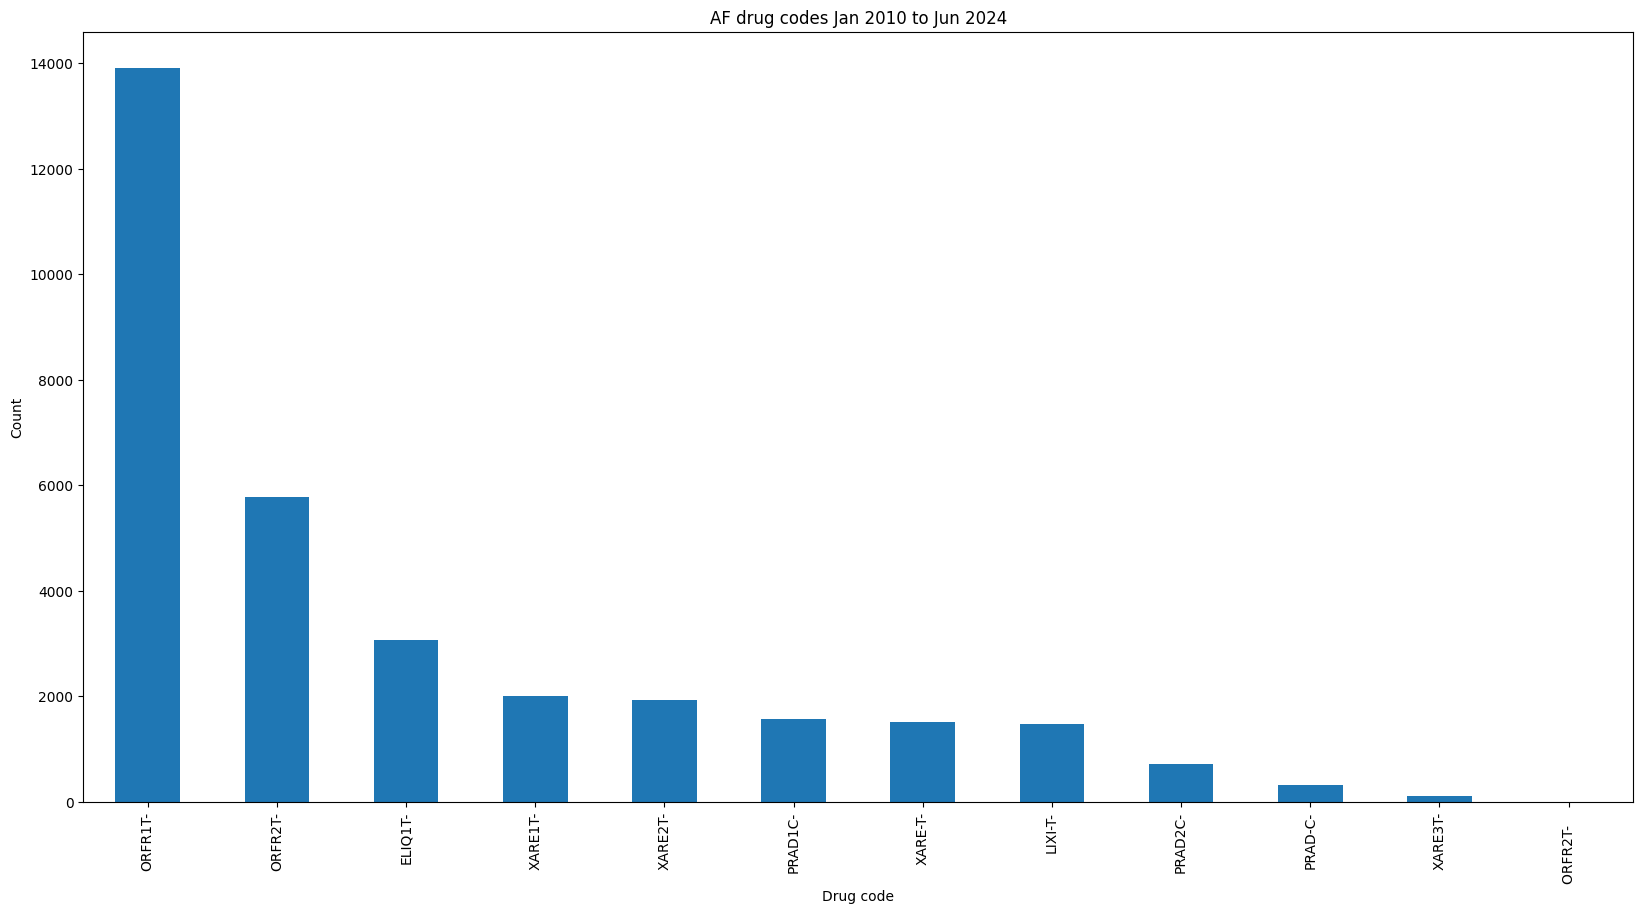

In [64]:
med.select('ENC_HN', 'D033KEY').unique().to_pandas()['D033KEY'].value_counts().plot(kind='bar', figsize=(20, 10), title='AF drug codes Jan 2010 to Jun 2024', xlabel='Drug code', ylabel='Count')

D033KEY
Warfarin sodium         19677
Rivaroxaban              5542
Apixaban                 3055
Dabigatran etexilate     2590
Edoxaban tosilate        1470
Name: count, dtype: int64

<Axes: title={'center': 'AF drugs from Jan 2010 to Jun 2024'}, xlabel='Drug name', ylabel='Count'>

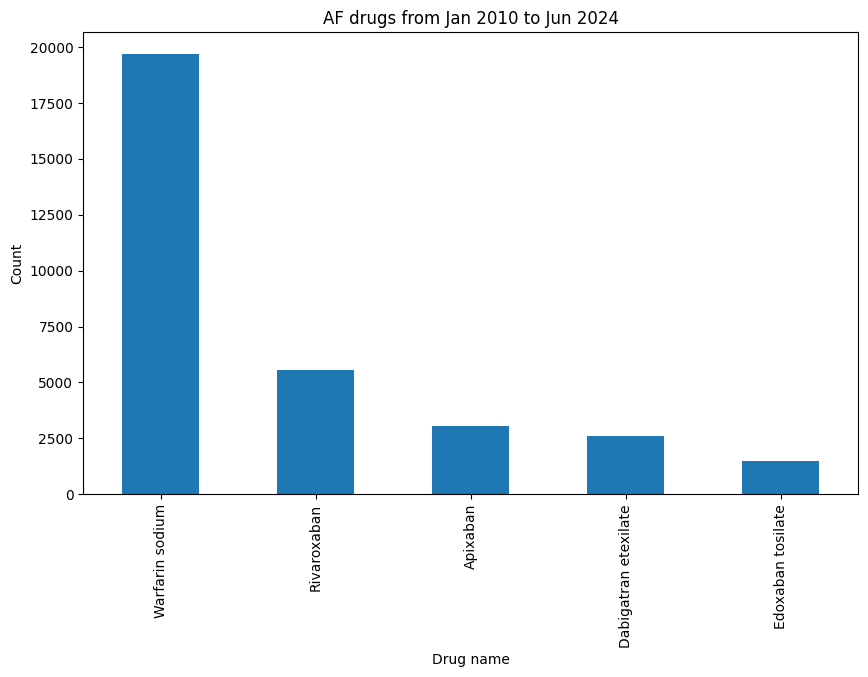

In [65]:
std_dict = dict(zip(af_std_df['CODE'], af_std_df['ชื่อสามัญ']))
std_cnt = med.select('ENC_HN', 'D033KEY').unique().to_pandas()['D033KEY'].map(std_dict).value_counts()
display(std_cnt)
std_cnt.plot(kind='bar', figsize=(10, 6), title='AF drugs from Jan 2010 to Jun 2024', xlabel='Drug name', ylabel='Count')

In [66]:
dx_paths = list(FOLDER_OC.dx.iterdir()) + list(FOLDER_NC.dx.iterdir())

dx = get_dx(dx_paths, re=af_icd_re, streaming=False)
dx

ENC_HN,D001KEY,D035KEY
str,date,str
"""E062BAC7B9046F…",2010-10-06,"""I48"""
"""04B8E0408DCB5C…",2010-03-15,"""I48"""
"""4093A0432891AF…",2010-06-13,"""I48"""
"""FBC59478BDCB67…",2010-01-12,"""I48"""
"""71185EA535FC97…",2010-12-20,"""I48"""
"""01BF39B9E04365…",2010-11-17,"""I48"""
"""901469F2D844B9…",2010-12-13,"""I48"""
"""96476E9D400CBA…",2010-05-10,"""I48"""
"""E1CED2B98EAF98…",2010-10-11,"""I48"""


In [67]:
dx['ENC_HN'].n_unique()

20856

In [68]:
def add_bool(df):
    return df.with_columns(
        pl.col('D035KEY').is_not_null().alias('ICD_exists'),
        pl.col('D033KEY').is_not_null().alias('Med_exists'),
        (pl.col('D035KEY').is_not_null() & pl.col('D033KEY').is_not_null()).alias('Both_exists'),
    )

In [69]:
combined = dx.join(med, on=['ENC_HN', 'D001KEY'], how='outer_coalesce',)
combined = add_bool(combined)
combined.write_csv(FOLDER_OUT / 'af_full_n=29636_Jun2024.csv')

In [70]:
combined

ENC_HN,D001KEY,D035KEY,D033KEY,M1022,ICD_exists,Med_exists,Both_exists
str,date,str,str,str,bool,bool,bool
"""C90B3BCAF1EB45…",2024-03-18,"""I480""","""LIXI-T-""","""5.071942446043…",true,true,true
"""C90B3BCAF1EB45…",2024-03-18,"""I480""","""LIXI-T-""","""24.92805755395…",true,true,true
"""EE007C9DFBDE08…",2024-03-25,"""I480""","""ORFR1T-""","""113""",true,true,true
"""1DDEE5D2492E14…",2024-03-11,null,"""ORFR1T-""","""266.6666666666…",false,true,false
"""B3C7264D401194…",2024-03-21,null,"""LIXI-T-""","""124.6402877697…",false,true,false
"""B3C7264D401194…",2024-03-21,null,"""LIXI-T-""","""25.35971223021…",false,true,false
"""BD1A2799C063A7…",2024-03-08,"""I480""","""LIXI-T-""","""6.762589928057…",true,true,true
"""1B7FE37D1F7ACE…",2024-03-06,null,"""ORFR1T-""","""33""",false,true,false
"""647B66F0E187A6…",2024-03-06,null,"""ORFR1T-""","""11.66666666666…",false,true,false


In [71]:
combined['ENC_HN'].n_unique()

29685

In [72]:
combined.group_by('ENC_HN').agg(
    pl.max('ICD_exists').alias('ICD_exists'),
    pl.max('Med_exists').alias('Med_exists'),
    pl.max('Both_exists').alias('Both_exists'),
).sum()

ENC_HN,ICD_exists,Med_exists,Both_exists
str,u32,u32,u32
null,20856,21109,10428


In [73]:
combined_filtered = clip_dates(combined, 'D001KEY', start_year=2024, start_month=1, start_day=1, end_year=2024, end_month=6, end_day=30)
combined_filtered = combined_filtered.filter(~pl.col('ENC_HN').is_in(prev_af))

In [74]:
combined_filtered['ENC_HN'].n_unique()

2665

In [75]:
combined_filtered.group_by('ENC_HN').agg(
    pl.max('ICD_exists').alias('ICD_exists'),
    pl.max('Med_exists').alias('Med_exists'),
    pl.max('Both_exists').alias('Both_exists'),
).sum()

ENC_HN,ICD_exists,Med_exists,Both_exists
str,u32,u32,u32
null,710,2259,229


# Combination with ECG / Holter

In [76]:
combined = pl.read_csv(FOLDER_OUT / 'af_full_n=29636_Jun2024.csv')

In [77]:
df_icd_new = (
    combined.groupby('ENC_HN').agg(
    pl.col('D001KEY').min()
    )
    .with_columns(pl.col('D001KEY').cast(pl.Date).alias('First_date'))
    .filter(pl.col('First_date').dt.year() == 2024)
    .select('ENC_HN', 'First_date')
)

df_icd_new

C:\Users\PC5\AppData\Local\Temp\ipykernel_153940\2270157968.py:2: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  combined.groupby('ENC_HN').agg(


ENC_HN,First_date
str,date
"""ED9FF8E6AB5690…",2024-03-07
"""1C2129DA793A21…",2024-04-02
"""D43F27A074A9C2…",2024-06-14
"""8F1D65BF52F054…",2024-02-22
"""A1CAEC18B7A7C0…",2024-01-07
"""B9EEF7D1DF5AC0…",2024-02-14
"""3D974A669129D6…",2024-02-09
"""18C8BCD7CDC1C6…",2024-05-21
"""5F64FDE10D07B2…",2024-01-29


In [78]:
df_ecgholter = (
    pl.read_excel(r"D:\Prut\Warehouses\output\Jun24\n\af\df_af_use_send.xlsx")
    .with_columns(pl.col('Date').cast(pl.Date))
    .filter(pl.col('Date').dt.year() == 2024)
    .filter(pl.col('Date').dt.month() <= 6)
)
assert len(df_ecgholter) == df_ecgholter.select('ENC_HN').n_unique()
df_ecgholter

ENC_HN,how,Date
str,str,date
"""EFF5117A1CB5DF…","""holter""",2024-03-12
"""1873948AF42279…","""holter""",2024-06-13
"""4C6FF132C85C18…","""holter""",2024-06-24
"""665825A27A6B5D…","""holter""",2024-04-26
"""D3D7481EB797CE…","""holter""",2024-05-31
"""81EB5B867657D2…","""holter""",2024-04-05
"""7ADECB0A456BD2…","""holter""",2024-02-07
"""C37111FE266884…","""holter""",2024-02-21
"""9A7A7BC215BE2B…","""holter""",2024-03-27


In [79]:
prev = pl.scan_parquet('D:/Prut/Warehouses/output/Dec23/wh/complete/AF_warehouse_exported_22-02-2024.parquet.gzip').select(pl.col('ENC_HN', 'Date')).unique().collect()

In [80]:
prev

ENC_HN,Date
str,date
"""002F3C3E57102D…",2011-01-28
"""34DD23802C9C3A…",2011-12-24
"""D8829EE1F50B04…",2011-08-08
"""FF8F096510EF3A…",2011-04-12
"""FFBC2A12C2D315…",2012-03-06
"""4336A26CDA8FCA…",2013-01-25
"""4D4BFE2A861F8A…",2013-11-26
"""68486BD0517E2C…",2013-10-08
"""FA76EBFFE30B78…",2013-01-09


In [81]:
df_prev = (
    prev.groupby('ENC_HN').agg(
    pl.col('Date').min()
    )
    .rename({'Date': 'First_date'})
    .filter(pl.col('First_date').dt.year() < 2024)
)
df_prev

C:\Users\PC5\AppData\Local\Temp\ipykernel_153940\305814982.py:2: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  prev.groupby('ENC_HN').agg(


ENC_HN,First_date
str,date
"""1C5DDCC7C5571C…",2012-01-24
"""8D1A9B61310D33…",2010-01-12
"""F50484FB53A537…",2017-11-23
"""5C410742A63B08…",2010-03-25
"""DA88B7C1648B26…",2013-11-12
"""E9740D4B06CAA5…",2018-08-14
"""B1D229CCB37292…",2011-01-05
"""9D2CE2287F4F5E…",2021-12-08
"""41A092BD6A18BA…",2010-04-02


In [82]:
df_prev

ENC_HN,First_date
str,date
"""1C5DDCC7C5571C…",2012-01-24
"""8D1A9B61310D33…",2010-01-12
"""F50484FB53A537…",2017-11-23
"""5C410742A63B08…",2010-03-25
"""DA88B7C1648B26…",2013-11-12
"""E9740D4B06CAA5…",2018-08-14
"""B1D229CCB37292…",2011-01-05
"""9D2CE2287F4F5E…",2021-12-08
"""41A092BD6A18BA…",2010-04-02


In [83]:
df_icd_new['ENC_HN'].unique() 

ENC_HN
str
"""9A82D11C6A6312…"
"""E2B92A50D1934E…"
"""27C5AA6085EF67…"
"""203091656D5523…"
"""D609B4D54D0143…"
"""0DF0E5261D75BA…"
"""8D95B00B615141…"
"""4B1D4A9CEC2393…"
"""F4D09F5D061672…"


In [85]:
df_ecgholter.select('ENC_HN').to_series().to_list()

['EFF5117A1CB5DF294C3F2931AF098A861EFE6C7D63E594FEA20C499BD3E60335',
 '1873948AF42279D988D97E03EACE4FED3771AC12B2DC67DA9C06BD8122FC0CBB',
 '4C6FF132C85C18F04F2C3C12B5F05CBF28602D9B7FCB9753D120991D40CC2B6A',
 '665825A27A6B5D3F6EED72FC377954C4788CEE68AC17D22270AF285F93397C56',
 'D3D7481EB797CE46EE84D8060C5B2BE20EFEBB31712F0EF709ED84D568FC0B93',
 '81EB5B867657D21FEDAD472C3C356A87C74DA94156460F6CC9F1E7BF402B49D9',
 '7ADECB0A456BD299CD924668C99E6EE10F510D7C90E78B8FAEC12ECE0C601CE2',
 'C37111FE266884067CED0C3598E3AAAD757A3F3997D571A9A8DDD5B0B83CCABE',
 '9A7A7BC215BE2B4E1F8DD8AED6D6C45A76B99D878D593CA9E298CDA00D753AFD',
 'C440155E32FC6C60EB420765890116414398ECA53D204D8BA3A973B74C2BD2E5',
 '1024616289BC82F69E851FB902BEB148CE3DA5DB1650BC6E3F2B6F90192156D1',
 'BB71A9C1AD827416D49B6287EBA6E70267D30DE54246EB080E9F48B9ADDC8594',
 '9F8AAD15A5FDF9ADDAAF405F6FFF75036820ED0595E8C242AAA54AE15B42B65A',
 'E6EBA6073EB659D4A811E841AE2E44FD9FE429C8FE8FAA0BBAE83B059B759168',
 '50853172585C4E8CB1D575FE33019B97

In [86]:
eh = df_ecgholter.filter(~pl.col("ENC_HN").is_in(df_prev.select('ENC_HN').to_series().to_list()))
eh

ENC_HN,how,Date
str,str,date
"""EFF5117A1CB5DF…","""holter""",2024-03-12
"""4C6FF132C85C18…","""holter""",2024-06-24
"""D3D7481EB797CE…","""holter""",2024-05-31
"""81EB5B867657D2…","""holter""",2024-04-05
"""9A7A7BC215BE2B…","""holter""",2024-03-27
"""1024616289BC82…","""holter""",2024-03-05
"""50853172585C4E…","""holter""",2024-03-22
"""84BC9C12A85E43…","""holter""",2024-05-30
"""69779A753BEB09…","""holter""",2024-05-01


In [87]:
eh.filter(pl.col("ENC_HN").is_in(df_icd_new.select('ENC_HN').to_series().to_list()))

ENC_HN,how,Date
str,str,date
"""EFF5117A1CB5DF…","""holter""",2024-03-12
"""69779A753BEB09…","""holter""",2024-05-01
"""E28C2923A226E9…","""holter""",2024-02-13
"""C473EB3B848500…","""holter""",2024-02-13
"""0F2DE605C9BFF3…","""holter""",2024-01-24
"""9BA3CAD5BECA29…","""holter""",2024-05-31
"""5BDCED29D3AC12…","""holter""",2024-02-22
"""A89007ABD6DAD0…","""holter""",2024-01-29
"""C539042D4191A1…","""holter""",2024-02-07


In [88]:
df_prev

ENC_HN,First_date
str,date
"""1C5DDCC7C5571C…",2012-01-24
"""8D1A9B61310D33…",2010-01-12
"""F50484FB53A537…",2017-11-23
"""5C410742A63B08…",2010-03-25
"""DA88B7C1648B26…",2013-11-12
"""E9740D4B06CAA5…",2018-08-14
"""B1D229CCB37292…",2011-01-05
"""9D2CE2287F4F5E…",2021-12-08
"""41A092BD6A18BA…",2010-04-02


In [89]:
df_icd_new

ENC_HN,First_date
str,date
"""ED9FF8E6AB5690…",2024-03-07
"""1C2129DA793A21…",2024-04-02
"""D43F27A074A9C2…",2024-06-14
"""8F1D65BF52F054…",2024-02-22
"""A1CAEC18B7A7C0…",2024-01-07
"""B9EEF7D1DF5AC0…",2024-02-14
"""3D974A669129D6…",2024-02-09
"""18C8BCD7CDC1C6…",2024-05-21
"""5F64FDE10D07B2…",2024-01-29


In [90]:
df_eh = eh.select('ENC_HN', 'Date').rename({'Date': 'First_date'})
df_eh

ENC_HN,First_date
str,date
"""EFF5117A1CB5DF…",2024-03-12
"""4C6FF132C85C18…",2024-06-24
"""D3D7481EB797CE…",2024-05-31
"""81EB5B867657D2…",2024-04-05
"""9A7A7BC215BE2B…",2024-03-27
"""1024616289BC82…",2024-03-05
"""50853172585C4E…",2024-03-22
"""84BC9C12A85E43…",2024-05-30
"""69779A753BEB09…",2024-05-01


In [91]:
df_cohort1 = pl.concat([df_prev, df_icd_new, df_eh]).group_by('ENC_HN').agg(pl.col('First_date').min())
df_cohort1

ENC_HN,First_date
str,date
"""20DF90A091549B…",2010-01-11
"""C0793ACE49E143…",2019-10-16
"""DBA65C7E4A20E0…",2012-01-13
"""9FEF97BD4264A1…",2014-05-22
"""3DFC42BF922057…",2019-10-24
"""3E0C1528E2C0C2…",2014-12-02
"""F445E331323AF9…",2020-03-13
"""1D8169CC5FDE4F…",2017-01-06
"""07353C79A518D0…",2021-10-03


In [92]:
df_cohort2 = df_cohort1.filter(pl.col('First_date').dt.year() >= 2010)
df_cohort2

ENC_HN,First_date
str,date
"""20DF90A091549B…",2010-01-11
"""C0793ACE49E143…",2019-10-16
"""DBA65C7E4A20E0…",2012-01-13
"""9FEF97BD4264A1…",2014-05-22
"""3DFC42BF922057…",2019-10-24
"""3E0C1528E2C0C2…",2014-12-02
"""F445E331323AF9…",2020-03-13
"""1D8169CC5FDE4F…",2017-01-06
"""07353C79A518D0…",2021-10-03


In [98]:
df_cohort2.write_csv(FOLDER_OUT / 'af_cohort_n=24944_Jun2024.csv')

In [97]:
df_cohort2['ENC_HN'].n_unique()

24944

---